# Optimal portfolio weights


##  1 Financial data collection

This first part of the script collects the financial data from the web. The user can choose the time frame, the number of stocks to be included, and how to handle missing values.

As yahoo finance and google finance closed their API we use Quandl, they have a database containing detailed info for over 3000 US securities

In [ ]:
# if you have not done so yet you will need to install quandl in the Anaconda prompt with the command "anaconda install quandl"
import quandl
import pandas as pd

# This is a simple function for a Yes or no question, taken from https://gist.github.com/garrettdreyfus/8153571
def yes_or_no(question):
    reply = str(input(question+' (y/n): ')).lower().strip()
    if reply[0] == 'y':
        return True
    if reply[0] == 'n':
        return False
    else:
        return yes_or_no("Uhhhh... please enter y/n")


def get_dates():
    # get user input for timeframe, it shoould be a string in format "YYYY-MM-DD"
    # example input: start = "2010-05-01" end = "2010-07-20"
    start  = input("Please enter your desired start date in the format: YYYY-MM-DD")
    end = input("Please enter your desired end date in the format: YYYY-MM-DD")
    return start, end


# function for getting the tickers
def get_ticker():
   
    # get userinput for amount of stocks they want
    n = int(input(" Please enter the amount of stocks you want to consider for your portfolio"))
    
    # create an empty list for the tickeres and then let the user enter the tickers, QUANDL only works with US-tickers
    # example inputs: tickers = ['AAPL', 'MSFT', 'WMT', "NKE"]
    
    tickers = [] 

    for i in range(0,n):
        tickers.append(input("Please Enter the Ticker/Symbol of stock number %i you are considering for your portfolio" % (i+1)))
    
    return n,tickers

# code from https://medium.com/python-data/quandl-getting-end-of-day-stock-data-with-python-8652671d6661
# get the table for daily stock prices and, filter the table for selected tickers, columns within a time range
# set paginate to True because Quandl limits tables API to 10,000 rows per call

def get_data(start, end, tickers):
    
    # using private API key
    quandl.ApiConfig.api_key = "FKSeudzRmxRVMU56b9MN"
    
    data = quandl.get_table("WIKI/PRICES", ticker = tickers, 
                        qopts = { "columns": ["ticker", "date", "adj_close"] }, 
                        date = { "gte": start, "lte": end }, 
                        paginate=True)

# create a new dataframe with "date" as index and use pivot to sort by tickers
    new = data.set_index("date")
    df = new.pivot(columns="ticker")
    return df

# calling the previously defined functions
start, end = get_dates()
n, tickers = get_ticker()
df=pd.DataFrame(get_data(start, end, tickers))


# The following while loop ensures that there is data of the proper length for all stocks, it is seperated into two parts:

while len(df.columns) != n or df.isnull().values.any() == True:
    
    # Part A  is to check whether all the Tickers were actually found as the quandl.get_table function simply omits unfound stocks
    #without an error message, user will be prompted to proceed with the ones that were found or to change his input, it will keep
    #asking until all the desired Tickers that can be found are in the dataframe.
    if len(df.columns) != n:
        print("Unfortunately only the following strings could be found:" + str(list(df)))
    
        if yes_or_no("Do you want to proceed anyways?") == False:
        
            n, tickers= get_ticker()
            df= pd.DataFrame(get_data(start, end, tickers))
        
        else:
        
            n= len(df.columns)
            
    # Part B makes sure all the samples are of equal length, this is crucial for the Cov-Matrix
    # There are three options: 1. drop the stocks (columns) with NaN values automatically  
    # 2. drop the dates (rows) with NaN values automatically 3. Reenter parameters manually
    # Note that if for stock x there is not a single observation, there will be no column for it(->part A)
    if df.isnull().values.any() == True:
        print("There seems to be data missing for the stock where it says true.")
        print(df.isnull().any())
    
        if yes_or_no("Do you want to drop these stocks?") == True:
            df= df.loc[:,df.isnull().any()==False]
            n= len(df.columns)
            
        elif yes_or_no("Do you want to have the duration of the shortened automatically?") == True:
            df = df.dropna(how="any")
            
        else:
            print("Please reenter the dates and the tickers")
            start, end = get_dates()
            n, tickers= get_ticker()
            df= pd.DataFrame(get_data(start, end, tickers))
            
# at this point there is a dataframe "df" with the daily prices and also the variable "n" = the amount of stocks in df
# all columns have the same amount of observations
# We do not have the risk free rate at this in case we actually want to get the tangency portfolio

print(n)        
df.head()

## 2 Mean-variance analysis

### 2.1 Mean returns and covariance

This part begins a mean-variance analysis of the user’s chosen stocks by computing the mean returns and the covariance matrix.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Convert closing prices to daily net returns
daily_net_return = df.pct_change(1)
daily_net_return = daily_net_return.iloc[1:]

# Compute mean returns and the covariance matrix
mean_returns = daily_net_return.mean()
cov_matrix = daily_net_return.cov()

### 2.2 Portfolio options (graphical representation) and Monte Carlo simulation

This first graphical representation gives an insight into the different portfolio options. Different levels of annual net returns (on the y-axes) are set for given level of risk (the standard deviation on the x-axes) and coloured by the different levels of average return earned in excess of the risk-free rate per unit of volatility (namely by the Sharpe Ratio). We are interested in the portfolio, that lies on the variance frontier and has the smallest risk, thus the smallest standard deviation. This part also starts constructing the minimum variance portfolio with the Monte Carlo simulation, which is used to include the impact of uncertainty in its prediction.



<function matplotlib.pyplot.show(*args, **kw)>

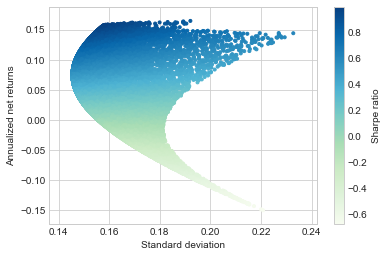

In [3]:
# Source: http://www.pythonforfinance.net/2017/01/21/investment-portfolio-optimisation-with-python/

# set number of runs of random portfolio weights
num_portfolios = 25000
 
# set up array to hold results
results = np.zeros((3,num_portfolios))
 
for i in range(num_portfolios):
    # select random weights for portfolio holdings
    weights = np.random.random(n)
    # rebalance weights to sum to 1
    weights /= np.sum(weights)
    
    # calculate portfolio annualized return and volatility
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights))) * np.sqrt(252)
    
    # store results in results array
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    # store Sharpe Ratio (return / volatility)
    results[2,i] = results[0,i] / results[1,i]

# convert results array to Pandas DataFrame
results_frame = pd.DataFrame(results.T,columns=['ret','stdev','sharpe'])
 
# create scatter plot coloured by Sharpe Ratio
plt.style.use('seaborn-whitegrid')
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,marker='.',cmap='GnBu')
plt.colorbar().set_label('Sharpe ratio')
plt.xlabel('Standard deviation')
plt.ylabel('Annualized net returns')
plt.show

### 2.3 Minimum variance portfolio

In this part the minimum variance portfolio, namely the portfolio with the least risks, is calculated by using a minimization problem in order to get the optimal weights of the user's selected stocks.

In [4]:
# We have already "constructed" the minimum variance portfolio above
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]

# Calculate minimum variance portfolio
# Source: https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f

import scipy.optimize as sco

def portfolio_annualised_performance(weights, mean_returns, cov_matrix): # callable function for sco.minimize
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

def portfolio_volatility(weights, mean_returns, cov_matrix): # callable function for sco.minimize
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = n
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

optimal_weights = min_variance(mean_returns, cov_matrix)['x']

### 2.4 Historical portfolio returns (graphical representation)

This part creates a graph representing the historical returns of the portfolio over the same time frame selected by the user. Furthermore, the optimization routine is compared to the Monte Carlo solution.

monte carlo:
ret       0.074337
stdev     0.145477
sharpe    0.510987
Name: 8434, dtype: float64
optimization:
0.07455631840823572 0.14547627830572082


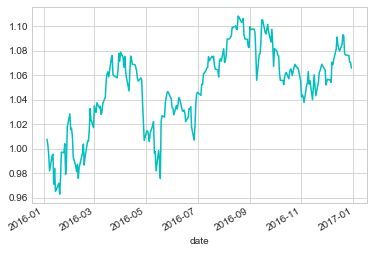

In [5]:
# Compute historical returns of the portfolio
def port_ret(optimal_weights, daily_net_return):
    port_ret = daily_net_return.mul(optimal_weights, axis=1).sum(axis=1)
    return port_ret

portfolio_return = port_ret(optimal_weights, daily_net_return)
cumulative_returns = ((1+portfolio_return).cumprod())
cumulative_returns.plot(color='c')

# Compare the optimization routine to the monte carlo solution
print('monte carlo:')
print(min_vol_port)
print('optimization:')
print(portfolio_return.mean()*252, portfolio_return.std()*np.sqrt(252)) # annualized

### 2.5 Cumulative portfolio resturns vs. Market Index (graphical representation)

This part plots a graph representing the historical cumulative returns of the portfolio compared to performance of the NASDAQ/NDX Index, whose data is collected from the web. This comparison is possible only for time range starting on 22th January 2003, since previous data are not available.

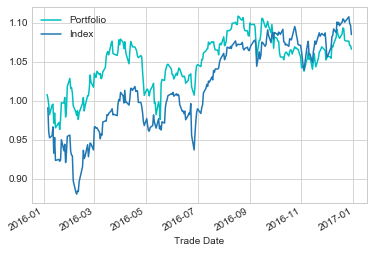

In [6]:
if end < "2003-01-22":
    print("This comparison is not available for your chosen time window")

# Get Market Index
market = quandl.get("NASDAQOMX/NDX", start_date=portfolio_return.index[0], end_date=portfolio_return.index[-1])["Index Value"]
daily_net_market = market.pct_change(1)
net_market = daily_net_market.iloc[1:]
cumulative_market = ((1+net_market).cumprod())

# As we can only get overall market data from 2003-01-22 we shorten the user's time window
portfolio_return2 = port_ret(optimal_weights, daily_net_return["2003-01-22":])

cumulative_returns2 = ((1+portfolio_return2).cumprod())

cumulative_returns2.plot(color='c',label='Portfolio')
cumulative_market.plot(label='Index')
plt.legend()

## 3 Risk measure


### 3.2 Value at Risk (graphical representation)

This part computes the statistical Value-at-risk (VaR), which measures the riskiness of the portfolio and plots an histogram of the distribution of the portfolio returns. It shows the maximum amount expected to be lost at the pre-defined confidence level of 95%.

/Users/laraschoni/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


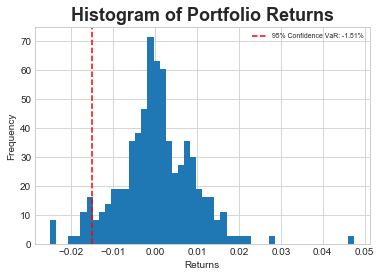

99.99% Confident the actual loss will not exceed:  -2.51%
99% Confident the actual loss will not exceed: -2.22%
95% Confident the actual loss will not exceed: -1.51%
Losses expected to exceed -1.51% 13 out of 251 days


In [7]:
# Source: https://programmingforfinance.com/2017/12/historical-value-at-risk-with-python/
# Sort Returns in Ascending Order
sorted_rets = sorted(portfolio_return)
    
varg = np.percentile(sorted_rets, 5)
    
# Output histogram
plt.hist(sorted_rets,50,normed=True)
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.title(r'Histogram of Portfolio Returns', fontsize=18, fontweight='bold')
plt.axvline(x=varg, color='r', linestyle='--', label='95% Confidence VaR: ' + "{0:.2f}%".format(varg * 100))
plt.legend(loc='upper right', fontsize = 'x-small')
plt.show()  
    
# VaR stats
print("99.99% Confident the actual loss will not exceed: " , "{0:.2f}%".format(np.percentile(sorted_rets, .01) * 100))
print("99% Confident the actual loss will not exceed: " + "{0:.2f}%".format(np.percentile(sorted_rets, 1) * 100))
print("95% Confident the actual loss will not exceed: " + "{0:.2f}%".format(np.percentile(sorted_rets, 5) * 100))

print("Losses expected to exceed " + "{0:.2f}%".format(np.percentile(sorted_rets, 5) * 100) + " " + str(round(.05*len(portfolio_return))) + " out of " + str(len(portfolio_return)) + " days")